In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_csv("local_data/df_final_scaled.csv")

In [3]:
numerical_data = data.filter(data.select_dtypes(["float64", "int64"]).columns)
numerical_data = numerical_data.fillna(numerical_data.median()).dropna(axis=1)
drop_cols = [
    "id",
    "host_id",
    "name",
    "neighbourhood_group",
    "neighbourhood",
    "last_review",
    "scrape_id",
    "price_per_person",
]
numerical_data = numerical_data.drop(
    columns=drop_cols, errors="ignore"
)  # ohne outliers
# numerical_data = numerical_data[
#     numerical_data["price"] < numerical_data["price"].quantile(0.99)
# ]

In [4]:
def transform_features(df: pd.DataFrame) -> pd.DataFrame:
    transformed_df = df.copy()

    numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
    if "price" in numeric_cols:
        numeric_cols.remove("price")

    sqrt_df = df[numeric_cols].apply(lambda x: np.sqrt(x - x.min() + 1))
    sqrt_df.columns = [f"sqrt_{col}" for col in numeric_cols]

    log_df = df[numeric_cols].apply(lambda x: np.log(x - x.min() + 1))
    log_df.columns = [f"log_{col}" for col in numeric_cols]

    # winsorisation
    wins_df = df[numeric_cols].apply(
        lambda x: stats.mstats.winsorize(x, limits=[0.023, 0.023])
    )
    wins_df.columns = [f"wins_{col}" for col in numeric_cols]

    return pd.concat([transformed_df, sqrt_df, log_df, wins_df], axis=1)


numerical_data_transformed = transform_features(numerical_data)

In [5]:
X = numerical_data_transformed.drop("price", axis=1)
y = numerical_data["price"]

In [6]:
numerical_data_transformed.sort_values("price", ascending=False).head(20)

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,wins_tourism_sportsactivitylocation,wins_tourism_store,wins_tourism_touristattraction,wins_tourism_winery,wins_tourism_zoo,wins_tourism_total,wins_tourism_points_within_radius,wins_noise_day,wins_noise_night,wins_noise_points_within_radius
1983,-2.883945,0.613276,-0.941741,-0.593848,-0.900460,-0.164740,-1.815901,-0.347049,-0.166115,-0.424399,...,0.456619,-0.644081,-0.552214,0.0,4.558440,0.092078,0.729226,-1.752516,-1.710399,0.018019
1346,-0.541997,0.780989,0.185794,-0.057522,-0.301757,0.342559,1.710725,2.030374,2.027178,1.432689,...,2.131090,0.528693,2.469606,0.0,0.533018,1.843654,1.408335,0.238603,0.235092,0.018019
2508,-2.870723,-2.186654,-0.371372,0.105984,-0.406207,0.388183,1.005910,-2.791826,1.101181,-0.424399,...,2.172599,0.628979,2.469606,0.0,1.540140,1.855951,1.408335,1.793658,1.908625,0.018019
1347,-0.541997,0.780989,0.185794,-0.057522,-0.301757,0.342559,1.710725,2.030374,2.027178,1.432689,...,2.131090,0.528693,2.469606,0.0,0.533018,1.843654,1.408335,0.238603,0.235092,0.018019
1343,-0.541997,0.780989,0.185794,-0.057522,-0.301757,0.342559,1.710725,2.030374,2.027178,1.432689,...,2.131090,0.528693,2.469606,0.0,0.533018,1.843654,1.408335,0.238603,0.235092,0.018019
1945,0.500091,0.780989,0.185794,-0.057522,-1.881367,-0.030686,2.459671,3.563316,3.371313,2.338784,...,1.731012,-0.657284,-0.577816,0.0,-0.227457,-1.018246,-0.969560,-0.798758,-0.728294,0.018019
1036,-1.331230,-0.216219,0.575495,0.338220,-0.581842,0.358342,1.710725,3.563316,3.371313,-2.755042,...,2.304674,-0.383877,2.468733,0.0,4.558440,1.646199,1.396694,0.416514,0.537111,0.018019
899,0.500091,0.613276,-0.941741,-1.116436,-0.933841,0.714243,1.005910,-0.347049,-0.166115,-0.424399,...,1.324604,2.023742,1.477921,0.0,-0.042784,1.283557,1.036853,0.956689,1.056466,0.018019
891,-0.257862,0.780989,1.136037,1.091916,-0.969914,-0.420063,2.151980,3.563316,-0.166115,1.946207,...,2.052742,-0.653391,-0.577646,0.0,-0.113736,-0.403130,0.009951,1.185200,1.282143,0.018019
1078,0.500091,0.696762,0.787068,0.562603,-0.881944,0.690996,1.953418,1.088974,2.027178,1.432689,...,2.037357,2.108852,2.208264,0.0,0.064623,1.477539,1.101867,-0.116231,-0.076249,0.018019


In [7]:
y.describe()

count    3.081000e+03
mean     1.688144e-15
std      1.000162e+00
min     -4.063636e+00
25%     -5.721695e-01
50%      9.879326e-03
75%      6.144971e-01
max      4.365877e+00
Name: price, dtype: float64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=99
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [9]:
cv = KFold(n_splits=5, shuffle=True, random_state=99)

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

rf = RandomForestRegressor()

param_dist = {
    "n_estimators": randint(100, 500),
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=15,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=99,
)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


# # Define a distribution of parameters to sample from
# param_distributions = {
#     # Continuous range for max_features using uniform distribution
#     'max_features': uniform(0.1, 1.0),

#     # Integer range for number of estimators
#     'n_estimators': randint(50, 500),

#     # Continuous range for minimum samples split
#     'min_samples_split': uniform(0.1, 0.9),

#     # Continuous range for minimum samples leaf
#     'min_samples_leaf': uniform(0.01, 0.2),

#     # Maximum depth with more nuanced sampling
#     'max_depth': [None] + list(randint(10, 50).rvs(10))
# }

# # Create a base random forest regressor
# rf = RandomForestRegressor(random_state=99)

# # Perform randomized search with cross-validation
# random_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param_distributions,
#     n_iter=100,  # Number of parameter settings that are sampled
#     cv=5,  # 5-fold cross-validation
#     n_jobs=-1,  # Use all available cores
#     verbose=2,  # Show progress
#     random_state=42,  # For reproducibility
#     scoring='neg_mean_squared_error'  # Optimization metric
# )

# # Fit the randomized search to the data
# random_search.fit(X_train, y_train)

# # Print the best parameters
# print("Best Parameters:", random_search.best_params_)

# # Get the best estimator
# best_rf = random_search.best_estimator_

# # Evaluate the best model
# train_score = best_rf.score(X_train, y_train)
# test_score = best_rf.score(X_test, y_test)

# print(f"Train R² Score: {train_score:.4f}")
# print(f"Test R² Score: {test_score:.4f}")

# # Optional: Inspect the results
# results = random_search.cv_results_
# for mean_score, params in zip(results['mean_test_score'], results['params']):
#     print(f"Mean Score: {-mean_score:.4f}, Params: {params}")

Best Parameters: {'max_depth': 30, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 240}
Best Score: -0.48345547601481165


In [11]:
# id, accomodates, bathrooms, beds, bedrooms, noise night, noise day

In [19]:
# Random Forest


def perform_rf(X_train_scaled, y_train):
    rf = RandomForestRegressor(
        n_estimators=240,
        random_state=99,
        max_depth=30,
        min_samples_split=2,
        min_samples_leaf=3,
    )

    rf.fit(X_train_scaled, y_train)

    return rf


def evaluate_rf(rf, y_true, y_pred, dataset_name: str):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{dataset_name} Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")

    feature_importance = pd.DataFrame(
        {"feature": X.columns, "importance": rf.feature_importances_}
    ).sort_values(by="importance", ascending=False)

    return {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "feature_importance": feature_importance,
    }


def visualize_rf_performance(y_true, y_pred, feature_importance):
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))

    # Scatter, actual vs predicted
    axes[0].scatter(y_true, y_pred, alpha=0.5)
    axes[0].plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", lw=2
    )
    axes[0].set_title("Actual vs Predicted Values")
    axes[0].set_xlabel("Actual Values")
    axes[0].set_ylabel("Predicted Values")

    # feature_importance bar chart (top 10)

    top_features = feature_importance.head(10)
    sns.barplot(x="importance", y="feature", data=top_features, ax=axes[1])
    axes[1].set_title("Top 10 Most Important Features")
    axes[1].set_xlabel("Feature Importance")

    plt.tight_layout()
    plt.show()

train Metrics:
R² Score: 0.8885
MSE: 0.12
RMSE: 0.34
MAE: 0.22
test Metrics:
R² Score: 0.5623
MSE: 0.42
RMSE: 0.65
MAE: 0.47


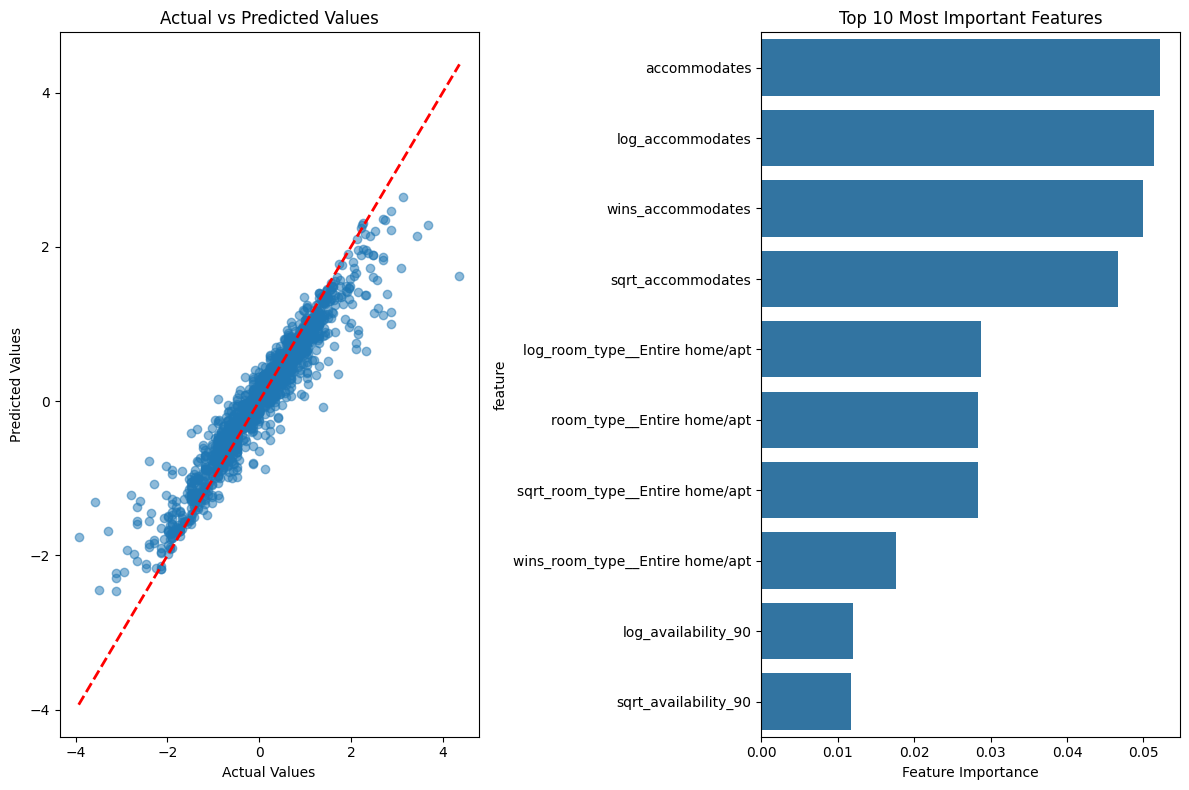

In [20]:
# Random forest

rf = perform_rf(X_train_scaled, y_train)  # fit random forest model

y_train_pred_rf = rf.predict(X_train_scaled)  # make predictions
y_test_pred_rf = rf.predict(X_test_scaled)

dict_rf1 = evaluate_rf(
    rf, y_train, y_train_pred_rf, "train"
)  # evaluate with MSE etc. and show most important features

mse1, rmse1, mae1, r21, feature_importance1 = evaluate_rf(
    rf, y_test, y_test_pred_rf, "test"
)

visualize_rf_performance(
    y_train, y_train_pred_rf, dict_rf1["feature_importance"]
)  # create scatter plot with actual vs predicted data, plot bar chart with most important features, or use Y_TEST_PRED_RF TO VISUALISE

In [21]:
lasso_cv = LassoCV(
    cv=cv,
    random_state=99,
    max_iter=100000,
    alphas=np.logspace(-2, 3, 100),
    selection="random",
    tol=1e-3,
    fit_intercept=True,
)

lasso_cv.fit(X_train_scaled, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.12332403e-02, 1.26185688e-02, 1.41747416e-02,
       1.59228279e-02, 1.78864953e-02, 2.00923300e-02, 2.25701972e-02,
       2.53536449e-02, 2.84803587e-02, 3.19926714e-02, 3.59381366e-02,
       4.03701726e-02, 4.53487851e-02, 5.09413801e-02, 5.72236766e-02,
       6.42807312e-02, 7.22080902e-02, 8.11130831e-02, 9.11162756e-02,
       1.02353102e-01, 1.14975700e-0...
       1.74752840e+02, 1.96304065e+02, 2.20513074e+02, 2.47707636e+02,
       2.78255940e+02, 3.12571585e+02, 3.51119173e+02, 3.94420606e+02,
       4.43062146e+02, 4.97702356e+02, 5.59081018e+02, 6.28029144e+02,
       7.05480231e+02, 7.92482898e+02, 8.90215085e+02, 1.00000000e+03]),
        cv=KFold(n_splits=5, random_state=99, shuffle=True), max_iter=100000,
        random_state=99, selection='random', tol=0.001)

Best regularization parameter: 0.01


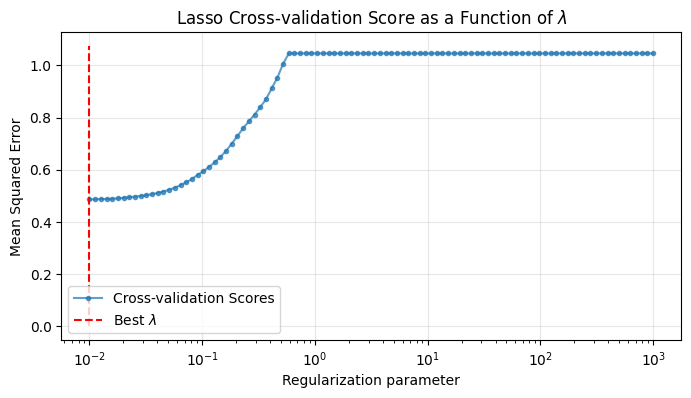

In [22]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(
    lasso_cv.alphas_,
    lasso_cv.mse_path_.mean(axis=1),
    marker="o",
    markersize=3,
    alpha=0.7,
    label="Cross-validation Scores",
)
# Plot the final chosen regularization parameter
ax.vlines(
    lasso_cv.alpha_,
    0,
    ax.get_ylim()[1],
    linestyle="--",
    color="red",
    label=r"Best $\lambda$",
)

# Aesthetics
ax.set_xscale("log")
ax.set_xlabel("Regularization parameter")
ax.set_ylabel("Mean Squared Error")
ax.set_title(r"Lasso Cross-validation Score as a Function of $\lambda$")
ax.grid(alpha=0.3)
ax.legend()

print(f"Best regularization parameter: {lasso_cv.alpha_:.2f}")

In [23]:
def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray, dataset_name: str) -> None:
    """"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{dataset_name} Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")


y_train_pred = lasso_cv.predict(X_train_scaled)
y_test_pred = lasso_cv.predict(X_test_scaled)

evaluate_model(y_train, y_train_pred, "train")
evaluate_model(y_test, y_test_pred, "test")


train Metrics:
R² Score: 0.5961
RMSE: 0.65
MAE: 0.48

test Metrics:
R² Score: 0.5385
RMSE: 0.66
MAE: 0.50


\coeffs:
                                                 feat     coeff
6                                        accommodates  0.286591
8                                            bedrooms  0.151178
394                       wins_minimum_nights_avg_ntm -0.133713
22                                  number_of_reviews -0.111992
374                  log_tourism_points_within_radius  0.091503
403                         wins_review_scores_rating  0.086701
21                                   availability_365  0.084606
340                    log_room_type__Entire home/apt  0.064091
88                         room_type__Entire home/apt  0.059405
385                                    wins_bathrooms  0.058903
217                       sqrt_room_type__Shared room -0.056388
36                                  reviews_per_month -0.053261
397                              wins_availability_60  0.050240
266                        log_minimum_maximum_nights  0.050143
9                              

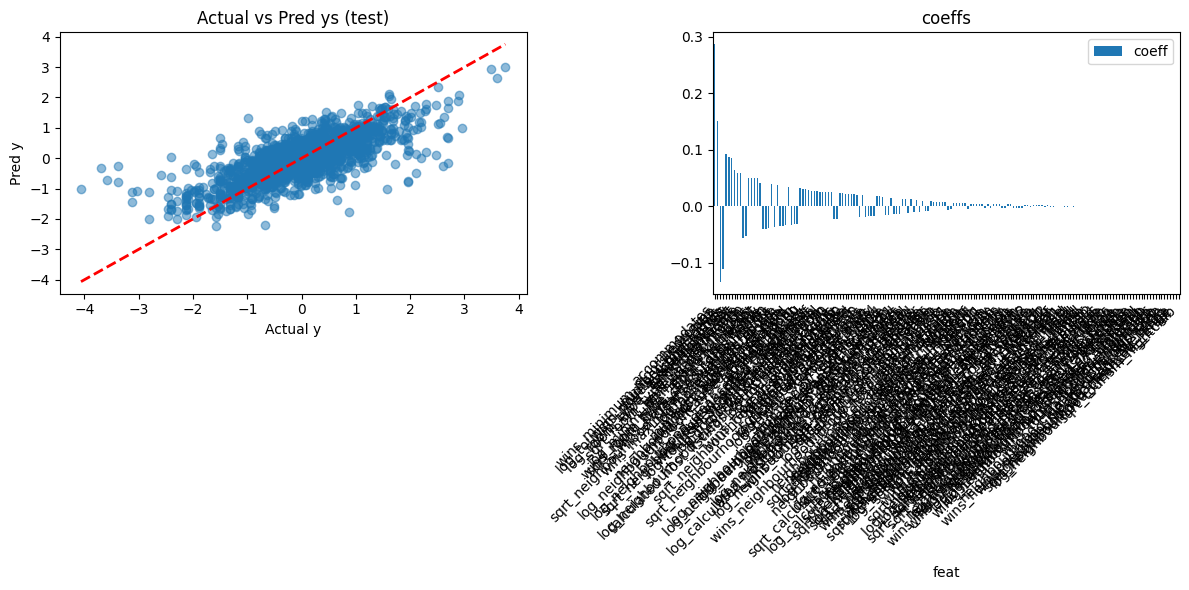

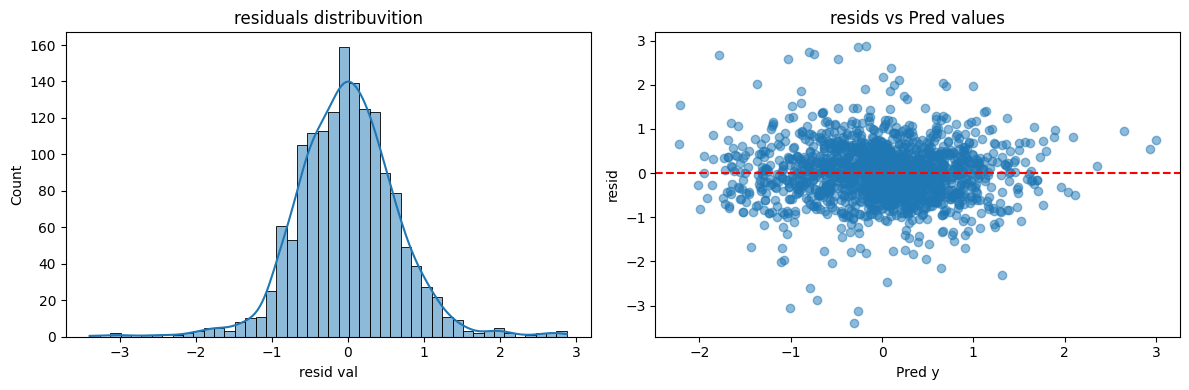

In [24]:
feature_importance = pd.DataFrame({"feat": X.columns, "coeff": lasso_cv.coef_})

feature_importance["Abs_coeff"] = abs(feature_importance["coeff"])
feature_importance_sorted = feature_importance.sort_values("Abs_coeff", ascending=False)
non_zero_features = feature_importance_sorted[feature_importance_sorted["coeff"] != 0]

print(r"\coeffs:")
print(non_zero_features[["feat", "coeff"]].to_string())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual y")
plt.ylabel("Pred y")
plt.title("Actual vs Pred ys (test)")

# Plot 2: feat coeffs
plt.subplot(1, 2, 2)
non_zero_features.plot(kind="bar", x="feat", y="coeff", ax=plt.gca())
plt.xticks(rotation=45, ha="right")
plt.title("coeffs")
plt.tight_layout()
plt.show()

residuals = y_test - y_test_pred

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title("residuals distribuvition")
plt.xlabel("resid val")

plt.subplot(1, 2, 2)
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Pred y")
plt.ylabel("resid")
plt.title("resids vs Pred values")
plt.tight_layout()
plt.show()

In [25]:
coefficient_df = pd.DataFrame(
    {
        "feature": X.columns,
        "coeff": lasso_cv.coef_,
        "coeff_abs": abs(lasso_cv.coef_),
    }
)

coefficient_df = coefficient_df.sort_values("coeff_abs", ascending=False)
coefficient_df

,feature,coeff,coeff_abs
6,accommodates,0.286591,0.286591
8,bedrooms,0.151178,0.151178
394,wins_minimum_nights_avg_ntm,-0.133713,0.133713
22,number_of_reviews,-0.111992,0.111992
374,log_tourism_points_within_radius,0.091503,0.091503
...,...,...,...
210,sqrt_neighbourhood_cleansed__Werd,0.000000,0.000000
208,sqrt_neighbourhood_cleansed__Unterstrass,0.000000,0.000000
205,sqrt_neighbourhood_cleansed__Seebach,-0.000000,0.000000
204,sqrt_neighbourhood_cleansed__Schwamendingen-Mitte,-0.000000,0.000000
